In [3]:
!pip3 uninstall -y kaggle
!pip3 install --upgrade pip
!pip3 install kaggle==1.5.6
!kaggle -v

Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (19.3.1)
Processing /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674/kaggle-1.5.6-cp36-none-any.whl
Kaggle API 1.5.6


In [4]:
!mkdir /root/.kaggle
## Upload the kaggle.json file.
!cp kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
!kaggle competitions download -c plant-seedlings-classification
!unzip plant-seedlings-classification.zip
!rm plant-seedlings-classification.zip sample_submission.csv

 99% 1.67G/1.69G [00:29<00:00, 51.1MB/s]
100% 1.69G/1.69G [00:29<00:00, 61.4MB/s]
Archive:  plant-seedlings-classification.zip
  inflating: sample_submission.csv   
  inflating: test/0021e90e4.png      
  inflating: test/003d61042.png      
  inflating: test/007b3da8b.png      
  inflating: test/0086a6340.png      
  inflating: test/00c47e980.png      
  inflating: test/00d090cde.png      
  inflating: test/00ef713a8.png      
  inflating: test/01291174f.png      
  inflating: test/026716f9b.png      
  inflating: test/02cfeb38d.png      
  inflating: test/03566743d.png      
  inflating: test/03a2ee656.png      
  inflating: test/03e322a29.png      
  inflating: test/03ef36742.png      
  inflating: test/043449b0b.png      
  inflating: test/0437393b1.png      
  inflating: test/04814f36d.png      
  inflating: test/05341a8a6.png      
  inflating: test/060450d79.png      
  inflating: test/060f1dc84.png      
  inflating: test/0625f063b.png      
  inflating: test/063363305.png      

In [6]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

from tensorflow.keras.utils import to_categorical
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, MaxPooling2D, Lambda
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import keras.backend as K
import tensorflow as tf

import random
import matplotlib.pyplot as plt
import sys
import numpy as np

import os
import cv2
import math
import itertools
import pandas as pd

from glob import glob
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.backend import set_session,tensorflow_backend

config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
config.gpu_options.per_process_gpu_memory_fraction = 0.5
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

Using TensorFlow backend.


## Constants

In [0]:
TRAIN_DIRECTORY = "train"
TEST_DIRECTORY = "test"
IMG_HEIGHT = 112
IMG_WIDTH = 112
CATEGORIES = os.listdir(TRAIN_DIRECTORY)
num_classes = len(CATEGORIES)

FILTER = True

## Load and prepare data

In [21]:
path_to_all_files = TRAIN_DIRECTORY + '/*/*.png' 
files = glob(path_to_all_files)

trainImg = []
trainLabel = []
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    trainImg.append(cv2.resize(cv2.imread(img), (IMG_WIDTH, IMG_HEIGHT)))  # Get image (with resizing)
    trainLabel.append(img.split('/')[-2])  # Get image label (folder name)

trainImg = np.asarray(trainImg)  # Train images set
trainLabel = pd.DataFrame(trainLabel)  # Train labels set

print(trainImg.shape)
print(trainLabel.shape)

(4750, 112, 112, 3)
(4750, 1)


In [44]:
path_to_all_files = TEST_DIRECTORY + '/*.png' 
files = glob(path_to_all_files)

testImg = []
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    testImg.append(cv2.resize(cv2.imread(img), (IMG_WIDTH, IMG_HEIGHT)))  # Get image (with resizing)

testImg = np.asarray(testImg)  # Train images set

print(testImg.shape)


(794, 112, 112, 3)


,0
0,Common wheat
1,Common wheat
2,Common wheat
3,Common wheat
4,Common wheat
...,...
4745,Maize
4746,Maize
4747,Maize
4748,Maize


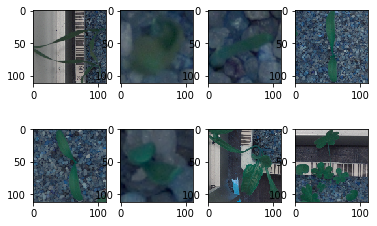

In [10]:
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(trainImg[i*100])

## Cleaning data

### Remove background

In [0]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [0]:
clearTrainImg = []
for img in trainImg:
    image = sharpen_image(segment_plant(img))
    clearTrainImg.append(image)
    
clearTrainImg = np.asarray(clearTrainImg)

In [0]:
clearTestImg = []
for img in testImg:
    image = sharpen_image(segment_plant(img))
    clearTestImg.append(image)
    
clearTestImg = np.asarray(clearTestImg)

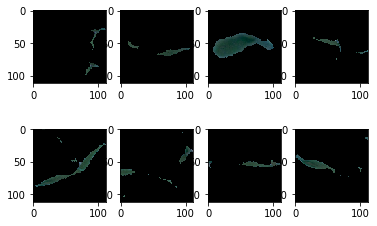

In [13]:
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(clearTrainImg[i*10])

## Normalise and change labels to categorical

In [0]:
#Use filtered data or not
if FILTER == False:
    trainImg = trainImg / 255
    testImg = testImg / 255
else:
    trainImg = clearTrainImg / 255
    testImg = clearTestImg / 255

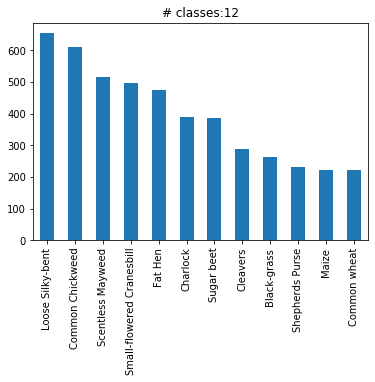

In [25]:
le = preprocessing.LabelEncoder()
encodeTrainLabels = le.fit_transform(trainLabel[0])
clearTrainLabel = to_categorical(encodeTrainLabels)

# Plot of label types numbers
trainLabel[0].value_counts().plot(kind='bar', title="# classes:" + str(clearTrainLabel.shape[1]))

### Train and validation, image generator

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(trainImg, clearTrainLabel, 
                                                test_size=0.2, random_state=33, 
                                                stratify = clearTrainLabel)

In [0]:
BATCH_SIZE = 16
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=180,  # randomly rotate images in the range
    zoom_range = 0.1, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1,  # randomly shift images vertically 
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=True)  # randomly flip images vertically

train_datagen.fit(X_train)

## Convolutional Auto Encoder Model

In [34]:
input_img = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)) 

x = Conv2D(filters=128, kernel_size=(5, 5), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(filters=32, kernel_size=(5, 5), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(filters=16, kernel_size=(5, 5), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
encoded = Flatten()(encoded)

x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (5, 5), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
autoencoder.summary()

encoder = Model(input_img, encoded)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 112, 112, 3)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 112, 112, 128)     9728      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 56, 56, 128)       512       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 56, 56, 64)        204864    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 32)        5123

In [35]:
autoencoder.fit_generator(
    train_datagen.flow(X_train, X_train, batch_size=BATCH_SIZE), 
                           epochs=20,
                           validation_data=(X_valid, X_valid), 
                           steps_per_epoch=(10 * X_train.shape[0]) / BATCH_SIZE)

Epoch 1/20
2375/2375 [==============================] - 166s 70ms/step - loss: 0.1773 - acc: 0.8044 - val_loss: 0.6515 - val_acc: 0.8060
Epoch 2/20
2375/2375 [==============================] - 166s 70ms/step - loss: 0.1736 - acc: 0.8048 - val_loss: 0.4993 - val_acc: 0.8060
Epoch 3/20
2375/2375 [==============================] - 165s 69ms/step - loss: 0.1727 - acc: 0.8048 - val_loss: 0.4127 - val_acc: 0.8059
Epoch 4/20
2375/2375 [==============================] - 164s 69ms/step - loss: 0.1726 - acc: 0.8046 - val_loss: 0.4651 - val_acc: 0.7862
Epoch 5/20
2375/2375 [==============================] - 163s 69ms/step - loss: 0.1720 - acc: 0.8047 - val_loss: 0.5900 - val_acc: 0.7160
Epoch 6/20
2375/2375 [==============================] - 163s 69ms/step - loss: 0.1718 - acc: 0.8049 - val_loss: 1.7803 - val_acc: 0.6187
Epoch 7/20
2375/2375 [==============================] - 162s 68ms/step - loss: 0.1717 - acc: 0.8046 - val_loss: 0.9342 - val_acc: 0.6860
Epoch 8/20
2375/2375 [===================

In [0]:
train_results = encoder.predict(trainImg)

In [0]:
test_results = encoder.predict(testImg)

In [48]:
test_results.shape

(794, 784)

In [0]:
np.savetxt('test.csv', test_results, delimiter=',')